# Predicting energy consumption based on weather data

### Introduction

The objective of this project is to build a model which is capable of predicting the expected energy consumption level based on weather data. Therefore a dataset which contains energy and weather data should be used, in order to detect and show possible corelations between weather data and energy demand. 

### The dataset
The dataset contains the following fields attributes:
- timestamp
- air_pressure[mmHg]
- air_temerature[degree celcius]
- relative_humudity[%]
- wind_speed[m/s]
- solar_irridiation[W/m^2]
- electricity_demand_values[kw]
- heat_demand_values[kw]

The dataset contains electrical and heat demand as well as weather data from december 2010 until november 2018 with an hourly resolution. It is critical to have fine-grained data points over a longer period of time in order to determine correlations between weather and energy demand. Furthermore, the energy demand data and weather data should not be spread across a wide geographical area, since discrepancies between the weather are more likely to occur and the quality of the data for training and evaluating the model are rapidly declining.

## Goals

For a better understanding of the dataset, a explorative data analysis will be done. The goal of this analysis is to detect which features correlate **strongly** with energy demand and which features *may* be less relevant.

In addition a model will be trained and evaluated, in order to gain insights wether weather data is suitable for predicting the energy demand or not.

In [87]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller, acf, grangercausalitytests
from statsmodels.tsa.seasonal import seasonal_decompose

np.random.seed(3)

In [88]:
df = pd.read_csv("./data/Load_data_new.csv")

## Exploratory Data Analysis

In [89]:
df.describe()

,air_pressure[mmHg],air_temperature[degree celcius],relative_humidity[%],wind_speed[M/S],solar_irridiation[W/m²],electricity_demand_values[kw],heat_demand_values[kw]
count,69934.000000,69903.000000,69903.000000,69125.000000,70080.000000,70073.000000,70073.000000
mean,734.588143,17.871834,60.644178,4.828268,257.293094,393.888975,263.506355
std,5.011322,10.683280,22.007274,2.598960,258.725788,239.189061,314.704564
min,716.500000,-14.400000,4.000000,0.000000,0.000000,112.947618,0.000000
25%,731.400000,10.000000,43.000000,3.000000,0.000000,227.707914,0.000000
50%,734.200000,18.900000,61.000000,5.000000,299.500000,323.093703,137.281603
75%,737.500000,25.600000,79.000000,6.000000,499.000000,476.911512,448.289876
max,757.500000,43.300000,100.000000,26.000000,699.000000,1592.893206,1529.168786


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70080 entries, 0 to 70079
Data columns (total 9 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Time                             70080 non-null  object 
 1   air_pressure[mmHg]               69934 non-null  float64
 2   air_temperature[degree celcius]  69903 non-null  float64
 3   relative_humidity[%]             69903 non-null  float64
 4   wind_speed[M/S]                  69125 non-null  float64
 5   solar_irridiation[W/m²]          70080 non-null  int64  
 6   total_cloud_cover[from ten]      69837 non-null  object 
 7   electricity_demand_values[kw]    70073 non-null  float64
 8   heat_demand_values[kw]           70073 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 4.8+ MB


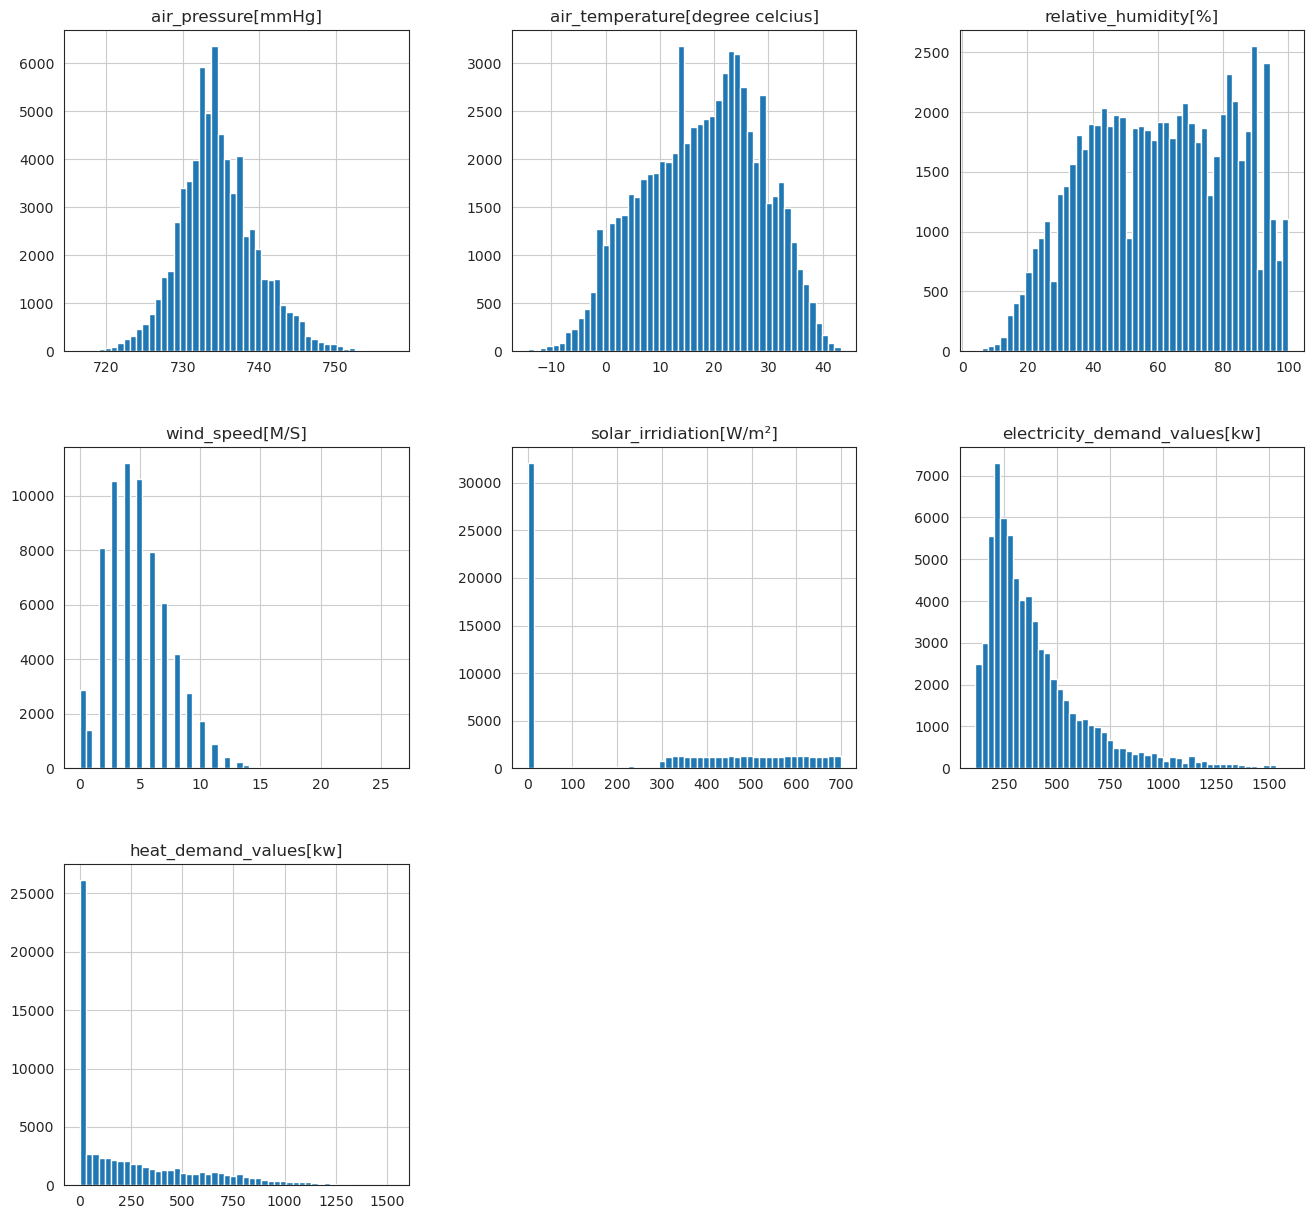

In [91]:
df.hist(bins=50, figsize=(16,15))
plt.show()

In [92]:
# Find NaN values in dataset to improve dataset quality.
df[df.isna().any(axis=1)]

,Time,air_pressure[mmHg],air_temperature[degree celcius],relative_humidity[%],wind_speed[M/S],solar_irridiation[W/m²],total_cloud_cover[from ten],electricity_demand_values[kw],heat_demand_values[kw]
130,2010-12-06 10:00:00,733.1,33.3,46.0,NaN,588,no clouds,333.817990,484.556708
375,2010-12-16 15:00:00,NaN,7.2,93.0,3.0,384,10/10.,375.382404,588.543953
376,2010-12-16 16:00:00,NaN,11.1,72.0,2.0,663,5/10.,451.820884,592.192796
613,2010-12-26 13:00:00,733.6,-2.2,96.0,7.0,600,NaN,381.252778,712.248685
1249,2011-01-22 01:00:00,736.8,20.6,93.0,9.0,0,NaN,290.154445,610.812280
...,...,...,...,...,...,...,...,...,...
68896,2018-10-10 16:00:00,728.6,19.0,94.0,4.0,460,NaN,244.096178,114.866493
69044,2018-10-16 20:00:00,NaN,5.0,70.0,5.0,0,no clouds,228.941001,81.630709
69046,2018-10-16 22:00:00,740.8,12.8,31.0,NaN,0,2/10–3/10.,258.874965,84.774228
69150,2018-10-21 06:00:00,743.2,10.0,26.0,NaN,0,7/10 – 8/10.,267.464345,10.436845


## Data Cleaning

In [93]:
df.isna().sum()

Time                                 0
air_pressure[mmHg]                 146
air_temperature[degree celcius]    177
relative_humidity[%]               177
wind_speed[M/S]                    955
solar_irridiation[W/m²]              0
total_cloud_cover[from ten]        243
electricity_demand_values[kw]        7
heat_demand_values[kw]               7
dtype: int64

**Note**: 
- NaN values for air_pressure, air_temperatur, relative_humidity are values which can be derived from previous and following values since radical inclines/declines in those features are not likely. 
- NaN values for wind speed and total cloud cover will be replaced with 0. 
- Also: cloud cover will be transformed to numeric values for better results when training the model.

In [94]:
# Interpolation of derivable values
df["air_pressure[mmHg]"].interpolate(inplace=True)
df["air_temperature[degree celcius]"].interpolate(inplace=True)
df["relative_humidity[%]"].interpolate(inplace=True)
df["heat_demand_values[kw]"].interpolate(inplace=True) # DEBUG
df["electricity_demand_values[kw]"].interpolate(inplace=True) # DEBUG

In [95]:
# Combine similar windspeed categories into one class
df["wind_speed_cat[M/S]"] = np.ceil(df["wind_speed[M/S]"])
df["wind_speed_cat[M/S]"].where(df["wind_speed[M/S]"] < 10, 10, inplace=True)

In [96]:
# Replace NaN for cloud_cover with 0
# Reshape total_cloud_cover to float
cloud_mapping = {
    'no clouds': 0,
    'Sky obscured by fog and/or other meteorological phenomena.': 0,
    'nan': 0,
    '2/10–3/10.': 0.25,
    '5/10.': 0.5,
    '10/10.': 1.0,
    '7/10 – 8/10.': 0.75,
    '4/10.': 0.4   
}
df["total_cloud_cover_numeric[from ten]"] = df["total_cloud_cover[from ten]"].apply(lambda x: cloud_mapping.get(x))
df["total_cloud_cover_numeric[from ten]"].fillna(value=0, inplace=True)

**Note**: wind_speed[M/S] & total_cloud_cover[from ten] were cleaned by adding further derived features.

In [97]:
df["DATETIME_NUMERIC"] = df["Time"].apply(pd.to_datetime)

## Checking for missing values

In [98]:
df_cleaned = df.copy()

In [99]:
df_cleaned.drop(columns=["wind_speed[M/S]", "total_cloud_cover[from ten]", "Time"], inplace=True)

In [100]:
# electricity_demand/heat_demand are not iterpolated.
df_cleaned.isnull().sum()

air_pressure[mmHg]                     0
air_temperature[degree celcius]        0
relative_humidity[%]                   0
solar_irridiation[W/m²]                0
electricity_demand_values[kw]          0
heat_demand_values[kw]                 0
wind_speed_cat[M/S]                    0
total_cloud_cover_numeric[from ten]    0
DATETIME_NUMERIC                       0
dtype: int64

## Checking for outliners

In [101]:
def visualize_box_plot(series: pd.Series):
    plt.rcParams.update({'figure.figsize': (10,10)})
    sns.boxplot(series)
    plt.show()

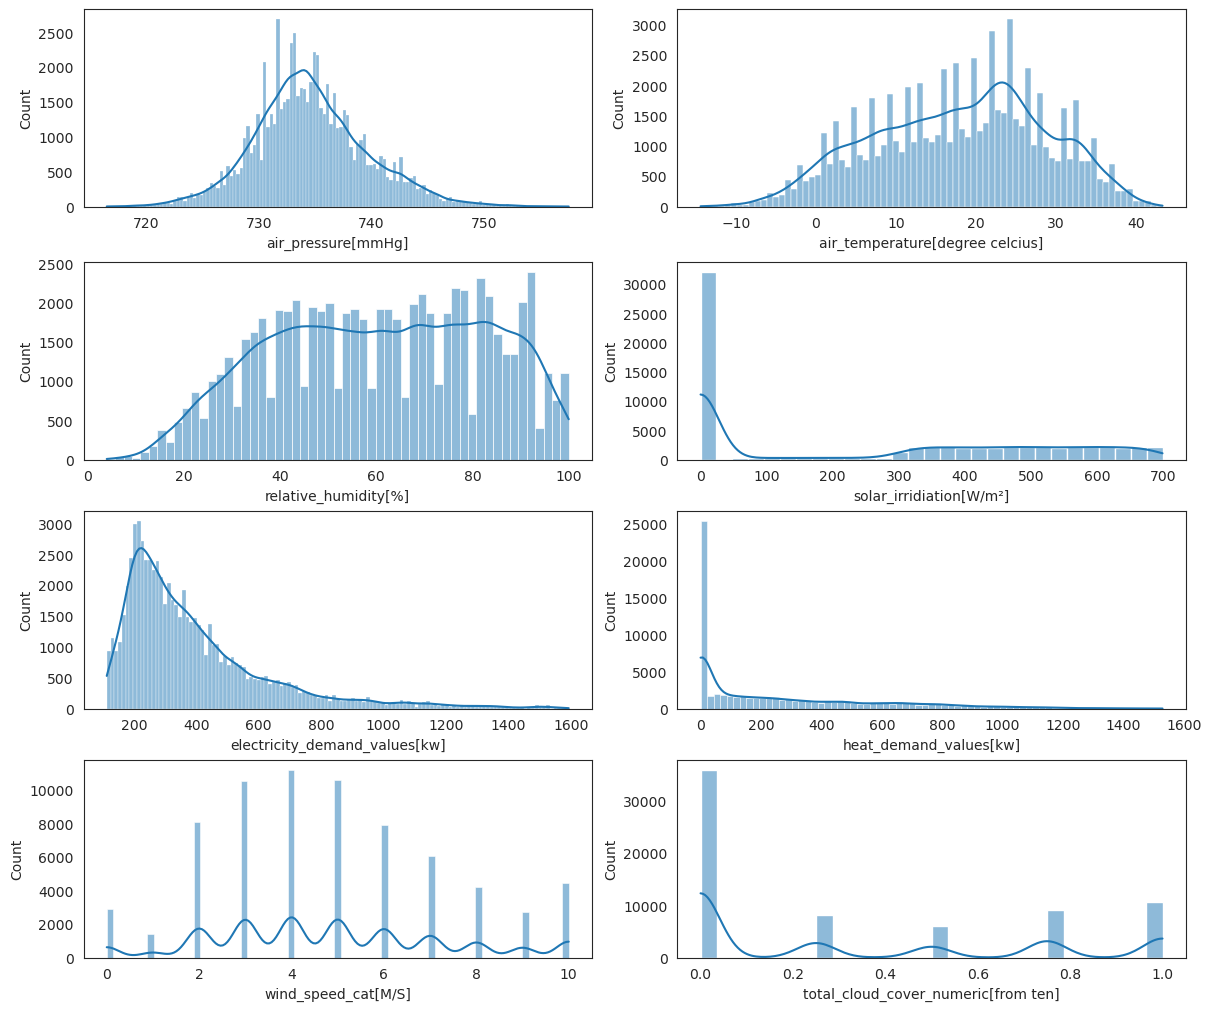

In [102]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12,10), constrained_layout=True)

for axx, column in zip(axes.flatten(), df_cleaned.columns):
    sns.set_style("white")
    sns.histplot(x=df_cleaned[column], data=df_cleaned, ax=axx, kde=True)

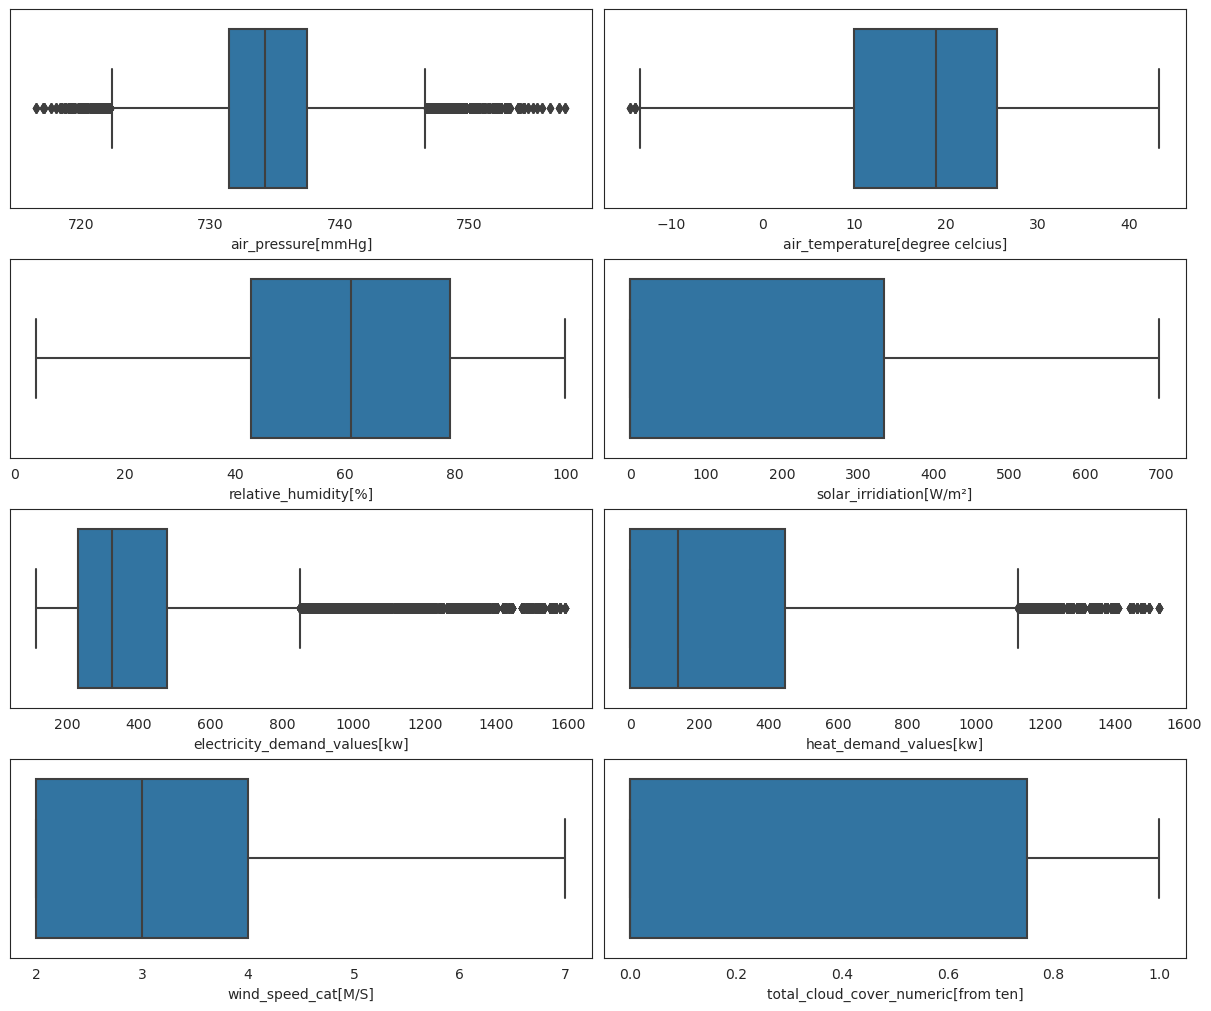

In [103]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12,10), constrained_layout=True)
for axx, column in zip(axes.flatten(), df_cleaned.columns):
    sns.set_style("white")
    sns.boxplot(df_cleaned[column], ax=axx, x=df_cleaned[column])

## Statistical Analysis

### Augmented Dickey-Fuller 
The Augmented Dickey-Fuller test can be used to test for a unit root in a univariate process in the presence of serial correlation. It is used to assess wether the timeseries data is stationary or not.

## Granger’s Causality Test

In [104]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests

In [105]:
maxlag = 12 # 12 Months

test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df


In [106]:
df_copy = df_cleaned.copy()
df_copy.set_index(keys="DATETIME_NUMERIC", inplace=True)
df_copy

,air_pressure[mmHg],air_temperature[degree celcius],relative_humidity[%],solar_irridiation[W/m²],electricity_demand_values[kw],heat_demand_values[kw],wind_speed_cat[M/S],total_cloud_cover_numeric[from ten]
DATETIME_NUMERIC,,,,,,,,
2010-12-01 00:00:00,729.7,25.0,85.0,0,289.567557,432.940036,5.0,0.00
2010-12-01 01:00:00,729.4,27.8,77.0,0,260.168520,473.935901,7.0,0.00
2010-12-01 02:00:00,728.9,33.3,62.0,0,247.273585,483.278761,7.0,0.25
2010-12-01 03:00:00,731.6,32.2,62.0,0,257.955878,545.921252,2.0,0.50
2010-12-01 04:00:00,732.6,22.8,96.0,0,258.255081,550.526112,3.0,0.25
...,...,...,...,...,...,...,...,...
2018-11-28 19:00:00,733.3,24.4,60.0,262,379.637300,626.192823,3.0,0.00
2018-11-28 20:00:00,733.6,27.8,56.0,0,369.976634,609.519358,4.0,0.00
2018-11-28 21:00:00,732.1,38.3,22.0,0,365.009491,571.465130,0.0,0.00


In [107]:
df_copy.dropna(inplace=True)
grangers_caustaiton_matrix_result = grangers_causation_matrix(df_copy, variables=df_copy.columns)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=-0.0000 , p=1.0000  , df_denom=70076, df_num=1
ssr based chi2 test:   chi2=-0.0000 , p=1.0000  , df=1
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=1
parameter F test:         F=385421.1658, p=0.0000  , df_denom=70076, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=-0.0000 , p=1.0000  , df_denom=70075, df_num=2
ssr based chi2 test:   chi2=-0.0000 , p=1.0000  , df=2
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=2
parameter F test:         F=205715.4912, p=0.0000  , df_denom=70075, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=70073, df_num=3
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=3
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=3
parameter F test:         F=142768.4822, p=0.0000  , df_denom=70073, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F

/home/ivan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 2
  warnings.warn('covariance of constraints does not have full '
/home/ivan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 4
  warnings.warn('covariance of constraints does not have full '
/home/ivan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 8, but rank is 2
  warnings.warn('covariance of constraints does not have full '
/home/ivan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 1
  warnings.warn('covariance of const

ssr based F test:         F=-8302.3288, p=1.0000  , df_denom=70063, df_num=8
ssr based chi2 test:   chi2=-66427.1622, p=1.0000  , df=8
likelihood ratio test: chi2=-207147.6459, p=1.0000  , df=8
parameter F test:         F=0.0376  , p=0.9631  , df_denom=70063, df_num=2

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=-6613.0855, p=1.0000  , df_denom=70061, df_num=9
ssr based chi2 test:   chi2=-59526.2644, p=1.0000  , df=9
likelihood ratio test: chi2=-132706.2250, p=1.0000  , df=9
parameter F test:         F=0.0047  , p=0.9451  , df_denom=70061, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=-4810.6264, p=1.0000  , df_denom=70059, df_num=10
ssr based chi2 test:   chi2=-48113.8171, p=1.0000  , df=10
likelihood ratio test: chi2=-81312.4485, p=1.0000  , df=10
parameter F test:         F=0.0107  , p=0.9178  , df_denom=70059, df_num=1

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=-144.2805, p=1.0000  , 

/home/ivan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 11, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/home/ivan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 12, but rank is 2
  warnings.warn('covariance of constraints does not have full '


ssr based F test:         F=3849.9026, p=0.0000  , df_denom=70076, df_num=1
ssr based chi2 test:   chi2=3850.0675, p=0.0000  , df=1
likelihood ratio test: chi2=3748.0287, p=0.0000  , df=1
parameter F test:         F=3849.9026, p=0.0000  , df_denom=70076, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=12302.9342, p=0.0000  , df_denom=70073, df_num=2
ssr based chi2 test:   chi2=24607.6242, p=0.0000  , df=2
likelihood ratio test: chi2=21090.2038, p=0.0000  , df=2
parameter F test:         F=12302.9342, p=0.0000  , df_denom=70073, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=12534.6789, p=0.0000  , df_denom=70070, df_num=3
ssr based chi2 test:   chi2=37607.7932, p=0.0000  , df=3
likelihood ratio test: chi2=30106.0421, p=0.0000  , df=3
parameter F test:         F=12534.6789, p=0.0000  , df_denom=70070, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=10125.2848, p=0.0000  , df_denom=7

parameter F test:         F=0.7425  , p=0.6359  , df_denom=70058, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.8508  , p=0.5576  , df_denom=70055, df_num=8
ssr based chi2 test:   chi2=6.8084  , p=0.5574  , df=8
likelihood ratio test: chi2=6.8080  , p=0.5575  , df=8
parameter F test:         F=0.8508  , p=0.5576  , df_denom=70055, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.6697  , p=0.7372  , df_denom=70052, df_num=9
ssr based chi2 test:   chi2=6.0290  , p=0.7370  , df=9
likelihood ratio test: chi2=6.0287  , p=0.7370  , df=9
parameter F test:         F=0.6697  , p=0.7372  , df_denom=70052, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.5842  , p=0.8284  , df_denom=70049, df_num=10
ssr based chi2 test:   chi2=5.8434  , p=0.8282  , df=10
likelihood ratio test: chi2=5.8431  , p=0.8283  , df=10
parameter F test:         F=0.5842  , p=0.8284  , df_denom=70049, df_num=10

G

ssr based F test:         F=2.1324  , p=0.0123  , df_denom=70043, df_num=12
ssr based chi2 test:   chi2=25.5983 , p=0.0122  , df=12
likelihood ratio test: chi2=25.5936 , p=0.0122  , df=12
parameter F test:         F=2.1324  , p=0.0123  , df_denom=70043, df_num=12

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1250.2940, p=0.0000  , df_denom=70076, df_num=1
ssr based chi2 test:   chi2=1250.3475, p=0.0000  , df=1
likelihood ratio test: chi2=1239.3241, p=0.0000  , df=1
parameter F test:         F=1250.2940, p=0.0000  , df_denom=70076, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3237.2951, p=0.0000  , df_denom=70073, df_num=2
ssr based chi2 test:   chi2=6475.0522, p=0.0000  , df=2
likelihood ratio test: chi2=6193.1493, p=0.0000  , df=2
parameter F test:         F=3237.2951, p=0.0000  , df_denom=70073, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2198.7403, p=0.0000  , df_denom=70070, df_

ssr based F test:         F=2039.9398, p=0.0000  , df_denom=70058, df_num=7
ssr based chi2 test:   chi2=14282.6363, p=0.0000  , df=7
likelihood ratio test: chi2=12998.8268, p=0.0000  , df=7
parameter F test:         F=2039.9398, p=0.0000  , df_denom=70058, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1851.4400, p=0.0000  , df_denom=70055, df_num=8
ssr based chi2 test:   chi2=14815.1139, p=0.0000  , df=8
likelihood ratio test: chi2=13439.7408, p=0.0000  , df=8
parameter F test:         F=1851.4400, p=0.0000  , df_denom=70055, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1417.5529, p=0.0000  , df_denom=70052, df_num=9
ssr based chi2 test:   chi2=12761.4367, p=0.0000  , df=9
likelihood ratio test: chi2=11723.6293, p=0.0000  , df=9
parameter F test:         F=1417.5529, p=0.0000  , df_denom=70052, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=996.1367, p=0.0000  , df_denom=7004

/home/ivan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 3
  warnings.warn('covariance of constraints does not have full '
/home/ivan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 3
  warnings.warn('covariance of constraints does not have full '
/home/ivan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 8, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/home/ivan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 1
  warnings.warn('covariance of const

ssr based F test:         F=-18.8405, p=1.0000  , df_denom=70065, df_num=7
ssr based chi2 test:   chi2=-131.8984, p=1.0000  , df=7
likelihood ratio test: chi2=-132.0227, p=1.0000  , df=7
parameter F test:         F=0.1867  , p=0.9055  , df_denom=70065, df_num=3

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=-0.1245 , p=1.0000  , df_denom=70063, df_num=8
ssr based chi2 test:   chi2=-0.9962 , p=1.0000  , df=8
likelihood ratio test: chi2=-0.9962 , p=1.0000  , df=8
parameter F test:         F=0.6344  , p=0.4258  , df_denom=70063, df_num=1

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=-5.4356 , p=1.0000  , df_denom=70060, df_num=9
ssr based chi2 test:   chi2=-48.9281, p=1.0000  , df=9
likelihood ratio test: chi2=-48.9452, p=1.0000  , df=9
parameter F test:         F=0.3157  , p=0.5742  , df_denom=70060, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=-6.0686 , p=1.0000  , df_denom=70059, df_num=10
ssr

/home/ivan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 11, but rank is 3
  warnings.warn('covariance of constraints does not have full '
/home/ivan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 12, but rank is 1
  warnings.warn('covariance of constraints does not have full '


ssr based F test:         F=-0.0372 , p=1.0000  , df_denom=70055, df_num=12
ssr based chi2 test:   chi2=-0.4469 , p=1.0000  , df=12
likelihood ratio test: chi2=-0.4469 , p=1.0000  , df=12
parameter F test:         F=0.4816  , p=0.4877  , df_denom=70055, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=801.9867, p=0.0000  , df_denom=70076, df_num=1
ssr based chi2 test:   chi2=802.0210, p=0.0000  , df=1
likelihood ratio test: chi2=797.4663, p=0.0000  , df=1
parameter F test:         F=801.9867, p=0.0000  , df_denom=70076, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=719.0997, p=0.0000  , df_denom=70073, df_num=2
ssr based chi2 test:   chi2=1438.3020, p=0.0000  , df=2
likelihood ratio test: chi2=1423.7408, p=0.0000  , df=2
parameter F test:         F=719.0997, p=0.0000  , df_denom=70073, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2175.6754, p=0.0000  , df_denom=70070, df_num=3
s

ssr based F test:         F=0.3010  , p=0.9537  , df_denom=70058, df_num=7
ssr based chi2 test:   chi2=2.1074  , p=0.9537  , df=7
likelihood ratio test: chi2=2.1073  , p=0.9537  , df=7
parameter F test:         F=0.3010  , p=0.9537  , df_denom=70058, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.3645  , p=0.9395  , df_denom=70055, df_num=8
ssr based chi2 test:   chi2=2.9169  , p=0.9395  , df=8
likelihood ratio test: chi2=2.9169  , p=0.9395  , df=8
parameter F test:         F=0.3645  , p=0.9395  , df_denom=70055, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.5311  , p=0.8530  , df_denom=70052, df_num=9
ssr based chi2 test:   chi2=4.7814  , p=0.8529  , df=9
likelihood ratio test: chi2=4.7813  , p=0.8529  , df=9
parameter F test:         F=0.5311  , p=0.8530  , df_denom=70052, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.6612  , p=0.7615  , df_denom=70049, df_num=10
ssr b

ssr based F test:         F=349.4050, p=0.0000  , df_denom=70043, df_num=12
ssr based chi2 test:   chi2=4194.3562, p=0.0000  , df=12
likelihood ratio test: chi2=4073.6119, p=0.0000  , df=12
parameter F test:         F=349.4050, p=0.0000  , df_denom=70043, df_num=12

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=72.0969 , p=0.0000  , df_denom=70076, df_num=1
ssr based chi2 test:   chi2=72.1000 , p=0.0000  , df=1
likelihood ratio test: chi2=72.0629 , p=0.0000  , df=1
parameter F test:         F=72.0969 , p=0.0000  , df_denom=70076, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2994.0999, p=0.0000  , df_denom=70073, df_num=2
ssr based chi2 test:   chi2=5988.6271, p=0.0000  , df=2
likelihood ratio test: chi2=5746.4465, p=0.0000  , df=2
parameter F test:         F=2994.0999, p=0.0000  , df_denom=70073, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1734.2947, p=0.0000  , df_denom=70070, df_nu

ssr based F test:         F=717.6194, p=0.0000  , df_denom=70058, df_num=7
ssr based chi2 test:   chi2=5024.4114, p=0.0000  , df=7
likelihood ratio test: chi2=4852.4525, p=0.0000  , df=7
parameter F test:         F=717.6194, p=0.0000  , df_denom=70058, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=600.4886, p=0.0000  , df_denom=70055, df_num=8
ssr based chi2 test:   chi2=4805.0747, p=0.0000  , df=8
likelihood ratio test: chi2=4647.4889, p=0.0000  , df=8
parameter F test:         F=600.4886, p=0.0000  , df_denom=70055, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=535.8571, p=0.0000  , df_denom=70052, df_num=9
ssr based chi2 test:   chi2=4824.0221, p=0.0000  , df=9
likelihood ratio test: chi2=4665.2161, p=0.0000  , df=9
parameter F test:         F=535.8571, p=0.0000  , df_denom=70052, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=472.5872, p=0.0000  , df_denom=70049, df_num=10

/home/ivan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 4
  warnings.warn('covariance of constraints does not have full '
/home/ivan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 8, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/home/ivan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/home/ivan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 10, but rank is 3
  warnings.warn('covariance of cons

ssr based F test:         F=-4.8066 , p=1.0000  , df_denom=70055, df_num=12
ssr based chi2 test:   chi2=-57.6903, p=1.0000  , df=12
likelihood ratio test: chi2=-57.7141, p=1.0000  , df=12
parameter F test:         F=0.2665  , p=0.8996  , df_denom=70055, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5234  , p=0.2171  , df_denom=70076, df_num=1
ssr based chi2 test:   chi2=1.5235  , p=0.2171  , df=1
likelihood ratio test: chi2=1.5234  , p=0.2171  , df=1
parameter F test:         F=1.5234  , p=0.2171  , df_denom=70076, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6004  , p=0.2018  , df_denom=70073, df_num=2
ssr based chi2 test:   chi2=3.2010  , p=0.2018  , df=2
likelihood ratio test: chi2=3.2009  , p=0.2018  , df=2
parameter F test:         F=1.6004  , p=0.2018  , df_denom=70073, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6782  , p=0.1693  , df_denom=70070, df_num=3
ssr 

/home/ivan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 12, but rank is 4
  warnings.warn('covariance of constraints does not have full '


ssr based F test:         F=0.7831  , p=0.6014  , df_denom=70058, df_num=7
ssr based chi2 test:   chi2=5.4831  , p=0.6012  , df=7
likelihood ratio test: chi2=5.4829  , p=0.6012  , df=7
parameter F test:         F=0.7831  , p=0.6014  , df_denom=70058, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.7690  , p=0.6302  , df_denom=70055, df_num=8
ssr based chi2 test:   chi2=6.1535  , p=0.6300  , df=8
likelihood ratio test: chi2=6.1532  , p=0.6301  , df=8
parameter F test:         F=0.7690  , p=0.6302  , df_denom=70055, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.5298  , p=0.8540  , df_denom=70052, df_num=9
ssr based chi2 test:   chi2=4.7693  , p=0.8539  , df=9
likelihood ratio test: chi2=4.7692  , p=0.8539  , df=9
parameter F test:         F=0.5298  , p=0.8540  , df_denom=70052, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.4978  , p=0.8926  , df_denom=70049, df_num=10
ssr b

ssr based F test:         F=1.8239  , p=0.0388  , df_denom=70043, df_num=12
ssr based chi2 test:   chi2=21.8942 , p=0.0387  , df=12
likelihood ratio test: chi2=21.8907 , p=0.0388  , df=12
parameter F test:         F=1.8239  , p=0.0388  , df_denom=70043, df_num=12

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=16.0541 , p=0.0001  , df_denom=70076, df_num=1
ssr based chi2 test:   chi2=16.0548 , p=0.0001  , df=1
likelihood ratio test: chi2=16.0530 , p=0.0001  , df=1
parameter F test:         F=16.0541 , p=0.0001  , df_denom=70076, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1534.4479, p=0.0000  , df_denom=70073, df_num=2
ssr based chi2 test:   chi2=3069.1148, p=0.0000  , df=2
likelihood ratio test: chi2=3003.8078, p=0.0000  , df=2
parameter F test:         F=1534.4479, p=0.0000  , df_denom=70073, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1357.4824, p=0.0000  , df_denom=70070, df_num=

ssr based F test:         F=0.1830  , p=0.9889  , df_denom=70058, df_num=7
ssr based chi2 test:   chi2=1.2815  , p=0.9889  , df=7
likelihood ratio test: chi2=1.2815  , p=0.9889  , df=7
parameter F test:         F=0.1830  , p=0.9889  , df_denom=70058, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.1826  , p=0.9933  , df_denom=70055, df_num=8
ssr based chi2 test:   chi2=1.4608  , p=0.9933  , df=8
likelihood ratio test: chi2=1.4608  , p=0.9933  , df=8
parameter F test:         F=0.1826  , p=0.9933  , df_denom=70055, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.1636  , p=0.9973  , df_denom=70052, df_num=9
ssr based chi2 test:   chi2=1.4727  , p=0.9973  , df=9
likelihood ratio test: chi2=1.4726  , p=0.9973  , df=9
parameter F test:         F=0.1636  , p=0.9973  , df_denom=70052, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.2369  , p=0.9926  , df_denom=70049, df_num=10
ssr b

ssr based F test:         F=0.6343  , p=0.8146  , df_denom=70043, df_num=12
ssr based chi2 test:   chi2=7.6149  , p=0.8145  , df=12
likelihood ratio test: chi2=7.6144  , p=0.8145  , df=12
parameter F test:         F=0.6343  , p=0.8146  , df_denom=70043, df_num=12

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=70077, df_num=1
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=1
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=1
parameter F test:         F=105453.8812, p=0.0000  , df_denom=70077, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=-0.0000 , p=1.0000  , df_denom=70075, df_num=2
ssr based chi2 test:   chi2=-0.0000 , p=1.0000  , df=2
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=2
parameter F test:         F=52946.2496, p=0.0000  , df_denom=70075, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=-0.0000 , p=1.0000  , df_denom=70073, df_num=

ssr based F test:         F=402.5677, p=0.0000  , df_denom=70058, df_num=7
ssr based chi2 test:   chi2=2818.5774, p=0.0000  , df=7
likelihood ratio test: chi2=2763.3666, p=0.0000  , df=7
parameter F test:         F=402.5677, p=0.0000  , df_denom=70058, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=356.4610, p=0.0000  , df_denom=70055, df_num=8
ssr based chi2 test:   chi2=2852.3802, p=0.0000  , df=8
likelihood ratio test: chi2=2795.8540, p=0.0000  , df=8
parameter F test:         F=356.4610, p=0.0000  , df_denom=70055, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=275.7332, p=0.0000  , df_denom=70052, df_num=9
ssr based chi2 test:   chi2=2482.2716, p=0.0000  , df=9
likelihood ratio test: chi2=2439.3158, p=0.0000  , df=9
parameter F test:         F=275.7332, p=0.0000  , df_denom=70052, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=222.8678, p=0.0000  , df_denom=70049, df_num=10

ssr based F test:         F=0.7744  , p=0.6777  , df_denom=70043, df_num=12
ssr based chi2 test:   chi2=9.2965  , p=0.6774  , df=12
likelihood ratio test: chi2=9.2958  , p=0.6775  , df=12
parameter F test:         F=0.7744  , p=0.6777  , df_denom=70043, df_num=12

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0573  , p=0.8108  , df_denom=70076, df_num=1
ssr based chi2 test:   chi2=0.0573  , p=0.8108  , df=1
likelihood ratio test: chi2=0.0573  , p=0.8108  , df=1
parameter F test:         F=0.0573  , p=0.8108  , df_denom=70076, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2702  , p=0.7632  , df_denom=70073, df_num=2
ssr based chi2 test:   chi2=0.5405  , p=0.7632  , df=2
likelihood ratio test: chi2=0.5405  , p=0.7632  , df=2
parameter F test:         F=0.2702  , p=0.7632  , df_denom=70073, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.3062  , p=0.0193  , df_denom=70070, df_num=3
ssr

ssr based F test:         F=1.9806  , p=0.0537  , df_denom=70058, df_num=7
ssr based chi2 test:   chi2=13.8671 , p=0.0536  , df=7
likelihood ratio test: chi2=13.8657 , p=0.0536  , df=7
parameter F test:         F=1.9806  , p=0.0537  , df_denom=70058, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.0971  , p=0.0325  , df_denom=70055, df_num=8
ssr based chi2 test:   chi2=16.7805 , p=0.0325  , df=8
likelihood ratio test: chi2=16.7785 , p=0.0325  , df=8
parameter F test:         F=2.0971  , p=0.0325  , df_denom=70055, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.7151  , p=0.0037  , df_denom=70052, df_num=9
ssr based chi2 test:   chi2=24.4422 , p=0.0037  , df=9
likelihood ratio test: chi2=24.4380 , p=0.0037  , df=9
parameter F test:         F=2.7151  , p=0.0037  , df_denom=70052, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.7598  , p=0.0021  , df_denom=70049, df_num=10
ssr b

/home/ivan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 3
  warnings.warn('covariance of constraints does not have full '
/home/ivan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 8, but rank is 4
  warnings.warn('covariance of constraints does not have full '
/home/ivan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 3
  warnings.warn('covariance of constraints does not have full '


ssr based F test:         F=-23.2443, p=1.0000  , df_denom=70055, df_num=12
ssr based chi2 test:   chi2=-278.9836, p=1.0000  , df=12
likelihood ratio test: chi2=-279.5405, p=1.0000  , df=12
parameter F test:         F=0.0032  , p=0.9998  , df_denom=70055, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=260.5177, p=0.0000  , df_denom=70076, df_num=1
ssr based chi2 test:   chi2=260.5288, p=0.0000  , df=1
likelihood ratio test: chi2=260.0458, p=0.0000  , df=1
parameter F test:         F=260.5177, p=0.0000  , df_denom=70076, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=388.6507, p=0.0000  , df_denom=70073, df_num=2
ssr based chi2 test:   chi2=777.3569, p=0.0000  , df=2
likelihood ratio test: chi2=773.0770, p=0.0000  , df=2
parameter F test:         F=388.6507, p=0.0000  , df_denom=70073, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=242.1770, p=0.0000  , df_denom=70070, df_num=3
ss

/home/ivan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 12, but rank is 3
  warnings.warn('covariance of constraints does not have full '


ssr based F test:         F=225.6645, p=0.0000  , df_denom=70058, df_num=7
ssr based chi2 test:   chi2=1579.9896, p=0.0000  , df=7
likelihood ratio test: chi2=1562.4403, p=0.0000  , df=7
parameter F test:         F=225.6645, p=0.0000  , df_denom=70058, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=217.4064, p=0.0000  , df_denom=70055, df_num=8
ssr based chi2 test:   chi2=1739.6735, p=0.0000  , df=8
likelihood ratio test: chi2=1718.4291, p=0.0000  , df=8
parameter F test:         F=217.4064, p=0.0000  , df_denom=70055, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=217.4766, p=0.0000  , df_denom=70052, df_num=9
ssr based chi2 test:   chi2=1957.8205, p=0.0000  , df=9
likelihood ratio test: chi2=1930.9682, p=0.0000  , df=9
parameter F test:         F=217.4766, p=0.0000  , df_denom=70052, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=303.5185, p=0.0000  , df_denom=70049, df_num=10

ssr based F test:         F=0.6919  , p=0.7610  , df_denom=70043, df_num=12
ssr based chi2 test:   chi2=8.3061  , p=0.7608  , df=12
likelihood ratio test: chi2=8.3056  , p=0.7608  , df=12
parameter F test:         F=0.6919  , p=0.7610  , df_denom=70043, df_num=12

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6235  , p=0.4297  , df_denom=70076, df_num=1
ssr based chi2 test:   chi2=0.6236  , p=0.4297  , df=1
likelihood ratio test: chi2=0.6236  , p=0.4297  , df=1
parameter F test:         F=0.6235  , p=0.4297  , df_denom=70076, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.1047  , p=0.0165  , df_denom=70073, df_num=2
ssr based chi2 test:   chi2=8.2100  , p=0.0165  , df=2
likelihood ratio test: chi2=8.2095  , p=0.0165  , df=2
parameter F test:         F=4.1047  , p=0.0165  , df_denom=70073, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.9872  , p=0.0298  , df_denom=70070, df_num=3
ssr

ssr based F test:         F=0.5707  , p=0.7804  , df_denom=70058, df_num=7
ssr based chi2 test:   chi2=3.9957  , p=0.7803  , df=7
likelihood ratio test: chi2=3.9956  , p=0.7803  , df=7
parameter F test:         F=0.5707  , p=0.7804  , df_denom=70058, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.5431  , p=0.8248  , df_denom=70055, df_num=8
ssr based chi2 test:   chi2=4.3456  , p=0.8247  , df=8
likelihood ratio test: chi2=4.3455  , p=0.8247  , df=8
parameter F test:         F=0.5431  , p=0.8248  , df_denom=70055, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.4156  , p=0.9276  , df_denom=70052, df_num=9
ssr based chi2 test:   chi2=3.7416  , p=0.9276  , df=9
likelihood ratio test: chi2=3.7415  , p=0.9276  , df=9
parameter F test:         F=0.4156  , p=0.9276  , df_denom=70052, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.5429  , p=0.8607  , df_denom=70049, df_num=10
ssr b

ssr based F test:         F=165.1924, p=0.0000  , df_denom=70043, df_num=12
ssr based chi2 test:   chi2=1983.0165, p=0.0000  , df=12
likelihood ratio test: chi2=1955.4740, p=0.0000  , df=12
parameter F test:         F=165.1924, p=0.0000  , df_denom=70043, df_num=12

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=-0.0000 , p=1.0000  , df_denom=70077, df_num=1
ssr based chi2 test:   chi2=-0.0000 , p=1.0000  , df=1
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=1
parameter F test:         F=6148521.8752, p=0.0000  , df_denom=70077, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=-0.0000 , p=1.0000  , df_denom=70075, df_num=2
ssr based chi2 test:   chi2=-0.0000 , p=1.0000  , df=2
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=2
parameter F test:         F=3870568.8945, p=0.0000  , df_denom=70075, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=70073, df

/home/ivan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 1
  warnings.warn('covariance of constraints does not have full '


ssr based F test:         F=0.0000  , p=1.0000  , df_denom=70065, df_num=7
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=7
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=7
parameter F test:         F=1272531.6527, p=0.0000  , df_denom=70065, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=-42.3078, p=1.0000  , df_denom=70063, df_num=8
ssr based chi2 test:   chi2=-338.5063, p=1.0000  , df=8
likelihood ratio test: chi2=-339.3265, p=1.0000  , df=8
parameter F test:         F=0.0269  , p=1.0000  , df_denom=70063, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=70061, df_num=9
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=9
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=9
parameter F test:         F=1013496.1750, p=0.0000  , df_denom=70061, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=-0.0000 , p=1.0000  , df_denom=70059, df_nu

parameter F test:         F=0.6703  , p=0.7817  , df_denom=70043, df_num=12

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=640.9333, p=0.0000  , df_denom=70076, df_num=1
ssr based chi2 test:   chi2=640.9608, p=0.0000  , df=1
likelihood ratio test: chi2=638.0473, p=0.0000  , df=1
parameter F test:         F=640.9333, p=0.0000  , df_denom=70076, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=367.5994, p=0.0000  , df_denom=70073, df_num=2
ssr based chi2 test:   chi2=735.2513, p=0.0000  , df=2
likelihood ratio test: chi2=731.4210, p=0.0000  , df=2
parameter F test:         F=367.5994, p=0.0000  , df_denom=70073, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=448.5359, p=0.0000  , df_denom=70070, df_num=3
ssr based chi2 test:   chi2=1345.7421, p=0.0000  , df=3
likelihood ratio test: chi2=1332.9835, p=0.0000  , df=3
parameter F test:         F=448.5359, p=0.0000  , df_denom=70070, df_num=3

Gra

likelihood ratio test: chi2=845.6000, p=0.0000  , df=8
parameter F test:         F=106.3145, p=0.0000  , df_denom=70055, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=82.6087 , p=0.0000  , df_denom=70052, df_num=9
ssr based chi2 test:   chi2=743.6801, p=0.0000  , df=9
likelihood ratio test: chi2=739.7613, p=0.0000  , df=9
parameter F test:         F=82.6087 , p=0.0000  , df_denom=70052, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=75.3298 , p=0.0000  , df_denom=70049, df_num=10
ssr based chi2 test:   chi2=753.5236, p=0.0000  , df=10
likelihood ratio test: chi2=749.5007, p=0.0000  , df=10
parameter F test:         F=75.3298 , p=0.0000  , df_denom=70049, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=69.4083 , p=0.0000  , df_denom=70046, df_num=11
ssr based chi2 test:   chi2=763.7420, p=0.0000  , df=11
likelihood ratio test: chi2=759.6097, p=0.0000  , df=11
parameter F test: 

ssr based F test:         F=2.3704  , p=0.0048  , df_denom=70043, df_num=12
ssr based chi2 test:   chi2=28.4554 , p=0.0047  , df=12
likelihood ratio test: chi2=28.4496 , p=0.0048  , df=12
parameter F test:         F=2.3704  , p=0.0048  , df_denom=70043, df_num=12

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5934  , p=0.4411  , df_denom=70076, df_num=1
ssr based chi2 test:   chi2=0.5934  , p=0.4411  , df=1
likelihood ratio test: chi2=0.5934  , p=0.4411  , df=1
parameter F test:         F=0.5934  , p=0.4411  , df_denom=70076, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5541  , p=0.5746  , df_denom=70073, df_num=2
ssr based chi2 test:   chi2=1.1083  , p=0.5746  , df=2
likelihood ratio test: chi2=1.1083  , p=0.5746  , df=2
parameter F test:         F=0.5541  , p=0.5746  , df_denom=70073, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4818  , p=0.6949  , df_denom=70070, df_num=3
ssr

/home/ivan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 2
  warnings.warn('covariance of constraints does not have full '
/home/ivan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 4
  warnings.warn('covariance of constraints does not have full '
/home/ivan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 2
  warnings.warn('covariance of constraints does not have full '
/home/ivan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 8, but rank is 3
  warnings.warn('covariance of const

ssr based F test:         F=-0.0483 , p=1.0000  , df_denom=70064, df_num=7
ssr based chi2 test:   chi2=-0.3384 , p=1.0000  , df=7
likelihood ratio test: chi2=-0.3384 , p=1.0000  , df=7
parameter F test:         F=0.2332  , p=0.7920  , df_denom=70064, df_num=2

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=-0.0184 , p=1.0000  , df_denom=70062, df_num=8
ssr based chi2 test:   chi2=-0.1471 , p=1.0000  , df=8
likelihood ratio test: chi2=-0.1471 , p=1.0000  , df=8
parameter F test:         F=0.0182  , p=0.9967  , df_denom=70062, df_num=3

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=-0.1885 , p=1.0000  , df_denom=70060, df_num=9
ssr based chi2 test:   chi2=-1.6965 , p=1.0000  , df=9
likelihood ratio test: chi2=-1.6966 , p=1.0000  , df=9
parameter F test:         F=0.4339  , p=0.7287  , df_denom=70060, df_num=3

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=-0.6561 , p=1.0000  , df_denom=70058, df_num=10
ssr b

/home/ivan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 10, but rank is 4
  warnings.warn('covariance of constraints does not have full '
/home/ivan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 11, but rank is 3
  warnings.warn('covariance of constraints does not have full '
/home/ivan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 12, but rank is 2
  warnings.warn('covariance of constraints does not have full '


ssr based F test:         F=-0.6728 , p=1.0000  , df_denom=70054, df_num=12
ssr based chi2 test:   chi2=-8.0748 , p=1.0000  , df=12
likelihood ratio test: chi2=-8.0752 , p=1.0000  , df=12
parameter F test:         F=0.3223  , p=0.7245  , df_denom=70054, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=128.5737, p=0.0000  , df_denom=70076, df_num=1
ssr based chi2 test:   chi2=128.5792, p=0.0000  , df=1
likelihood ratio test: chi2=128.4614, p=0.0000  , df=1
parameter F test:         F=128.5737, p=0.0000  , df_denom=70076, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=711.8359, p=0.0000  , df_denom=70073, df_num=2
ssr based chi2 test:   chi2=1423.7735, p=0.0000  , df=2
likelihood ratio test: chi2=1409.5031, p=0.0000  , df=2
parameter F test:         F=711.8359, p=0.0000  , df_denom=70073, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=501.7753, p=0.0000  , df_denom=70070, df_num=3
ss

ssr based F test:         F=256.9493, p=0.0000  , df_denom=70061, df_num=6
ssr based chi2 test:   chi2=1541.9817, p=0.0000  , df=6
likelihood ratio test: chi2=1525.2609, p=0.0000  , df=6
parameter F test:         F=256.9493, p=0.0000  , df_denom=70061, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=217.8462, p=0.0000  , df_denom=70058, df_num=7
ssr based chi2 test:   chi2=1525.2497, p=0.0000  , df=7
likelihood ratio test: chi2=1508.8870, p=0.0000  , df=7
parameter F test:         F=217.8462, p=0.0000  , df_denom=70058, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=185.6158, p=0.0000  , df_denom=70055, df_num=8
ssr based chi2 test:   chi2=1485.2865, p=0.0000  , df=8
likelihood ratio test: chi2=1469.7640, p=0.0000  , df=8
parameter F test:         F=185.6158, p=0.0000  , df_denom=70055, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=158.7632, p=0.0000  , df_denom=70052, df_num=9
s

ssr based F test:         F=0.7613  , p=0.6795  , df_denom=70046, df_num=11
ssr based chi2 test:   chi2=8.3768  , p=0.6792  , df=11
likelihood ratio test: chi2=8.3763  , p=0.6793  , df=11
parameter F test:         F=0.7613  , p=0.6795  , df_denom=70046, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=1.3521  , p=0.1812  , df_denom=70043, df_num=12
ssr based chi2 test:   chi2=16.2312 , p=0.1809  , df=12
likelihood ratio test: chi2=16.2293 , p=0.1810  , df=12
parameter F test:         F=1.3521  , p=0.1812  , df_denom=70043, df_num=12

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7770  , p=0.1825  , df_denom=70076, df_num=1
ssr based chi2 test:   chi2=1.7771  , p=0.1825  , df=1
likelihood ratio test: chi2=1.7771  , p=0.1825  , df=1
parameter F test:         F=1.7770  , p=0.1825  , df_denom=70076, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6297  , p=0.5328  , df_denom=70073, df_num=

ssr based F test:         F=100.7377, p=0.0000  , df_denom=70061, df_num=6
ssr based chi2 test:   chi2=604.5381, p=0.0000  , df=6
likelihood ratio test: chi2=601.9453, p=0.0000  , df=6
parameter F test:         F=100.7377, p=0.0000  , df_denom=70061, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=135.2504, p=0.0000  , df_denom=70058, df_num=7
ssr based chi2 test:   chi2=946.9558, p=0.0000  , df=7
likelihood ratio test: chi2=940.6144, p=0.0000  , df=7
parameter F test:         F=135.2504, p=0.0000  , df_denom=70058, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=100.2530, p=0.0000  , df_denom=70055, df_num=8
ssr based chi2 test:   chi2=802.2188, p=0.0000  , df=8
likelihood ratio test: chi2=797.6615, p=0.0000  , df=8
parameter F test:         F=100.2530, p=0.0000  , df_denom=70055, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=102.5986, p=0.0000  , df_denom=70052, df_num=9
ssr bas

/home/ivan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '
/home/ivan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 3
  warnings.warn('covariance of constraints does not have full '
/home/ivan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 4
  warnings.warn('covariance of constraints does not have full '
/home/ivan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 5
  warnings.warn('covariance of const

ssr based F test:         F=-1.5674 , p=1.0000  , df_denom=70063, df_num=6
ssr based chi2 test:   chi2=-9.4057 , p=1.0000  , df=6
likelihood ratio test: chi2=-9.4064 , p=1.0000  , df=6
parameter F test:         F=1.4143  , p=0.2154  , df_denom=70063, df_num=5

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=-8.2598 , p=1.0000  , df_denom=70064, df_num=7
ssr based chi2 test:   chi2=-57.8259, p=1.0000  , df=7
likelihood ratio test: chi2=-57.8497, p=1.0000  , df=7
parameter F test:         F=5.1166  , p=0.0001  , df_denom=70064, df_num=5

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=-2.0103 , p=1.0000  , df_denom=70062, df_num=8
ssr based chi2 test:   chi2=-16.0845, p=1.0000  , df=8
likelihood ratio test: chi2=-16.0864, p=1.0000  , df=8
parameter F test:         F=0.6564  , p=0.7093  , df_denom=70062, df_num=7

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=-3.6701 , p=1.0000  , df_denom=70060, df_num=9
ssr bas

/home/ivan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 8
  warnings.warn('covariance of constraints does not have full '
/home/ivan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 10, but rank is 4
  warnings.warn('covariance of constraints does not have full '
/home/ivan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 11, but rank is 7
  warnings.warn('covariance of constraints does not have full '
/home/ivan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 12, but rank is 6
  warnings.warn('covariance of co

In [108]:
grangers_caustaiton_matrix_result

,air_pressure[mmHg]_x,air_temperature[degree celcius]_x,relative_humidity[%]_x,solar_irridiation[W/m²]_x,electricity_demand_values[kw]_x,heat_demand_values[kw]_x,wind_speed_cat[M/S]_x,total_cloud_cover_numeric[from ten]_x
air_pressure[mmHg]_y,1.0000,0.0000,0.0000,0.6661,0.0193,0.0165,0.0000,0.0000
air_temperature[degree celcius]_y,0.0000,1.0000,0.0000,0.7285,0.0045,0.0663,0.0000,0.0000
relative_humidity[%]_y,0.0000,0.0000,1.0000,0.5018,0.0000,0.1706,0.0000,0.0000
solar_irridiation[W/m²]_y,0.0787,0.1372,0.0480,1.0000,0.0000,0.0000,0.2406,0.1809
electricity_demand_values[kw]_y,0.0917,0.4176,0.0001,0.0000,1.0000,0.0000,0.0027,0.1825
heat_demand_values[kw]_y,0.0040,0.0034,0.0061,0.0000,0.0000,1.0000,0.1958,0.0098
wind_speed_cat[M/S]_y,0.0000,0.0000,0.0000,0.5844,0.0015,0.0823,1.0000,0.0000
total_cloud_cover_numeric[from ten]_y,0.0000,0.0000,0.0000,0.5692,0.3848,0.0977,0.0000,1.0000


In [109]:
grangers_caustaiton_matrix_result.loc[["electricity_demand_values[kw]_y", "heat_demand_values[kw]_y"]]

,air_pressure[mmHg]_x,air_temperature[degree celcius]_x,relative_humidity[%]_x,solar_irridiation[W/m²]_x,electricity_demand_values[kw]_x,heat_demand_values[kw]_x,wind_speed_cat[M/S]_x,total_cloud_cover_numeric[from ten]_x
electricity_demand_values[kw]_y,0.0917,0.4176,0.0001,0.0,1.0,0.0,0.0027,0.1825
heat_demand_values[kw]_y,0.0040,0.0034,0.0061,0.0,0.0,1.0,0.1958,0.0098


### Interpretation of the result

Let's take the value 0.0031 (row 2, column 1) it refers to the p-value of `air_pressure[mmHg]_x` causing `heat_demand_values[kw]_y`. How do we interpret the p-values?

If a given p-value is less than the significance level (0.05), then, the corresponding X series(column) causes the Y (row). With other words, if p < alpha (significance level) the null hypothesis can be rejectect and the conclusion that X causes Y can be done. 

How can we use this result?

H0: X does not granger cause Y\
H1: X does granger cause Y, **if p-value > 0.05 then H0 is accepted**, i.e. X does not granger cause Y.

What does this mean for the dataset?
If we take a look at the `electricity_demand_values[kw]_y` and `heat_demand_values[kw]_y` we can see that some of the p-values for some `Xs` are **> 0.05**. This means that the null hypothesis *X does not cause Y* can be accepted. For the furhter predictions we should split the dataset into two. One for predicting `electricity_demand_values[kw]` and one for predicting `heat_demand_values[kw]`. 

In [110]:
df_heat_raw = df_cleaned.copy()
df_elec_raw = df_cleaned.copy()

In [111]:
# Drop columns in both dataframes where H0 is accepted.
df_heat = df_heat_raw.drop(columns=["electricity_demand_values[kw]","wind_speed_cat[M/S]"])
df_elec = df_elec_raw.drop(columns=[ "heat_demand_values[kw]", "air_pressure[mmHg]", "air_temperature[degree celcius]", "total_cloud_cover_numeric[from ten]"])

In [112]:
df_heat.info()
df_elec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70080 entries, 0 to 70079
Data columns (total 7 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   air_pressure[mmHg]                   70080 non-null  float64       
 1   air_temperature[degree celcius]      70080 non-null  float64       
 2   relative_humidity[%]                 70080 non-null  float64       
 3   solar_irridiation[W/m²]              70080 non-null  int64         
 4   heat_demand_values[kw]               70080 non-null  float64       
 5   total_cloud_cover_numeric[from ten]  70080 non-null  float64       
 6   DATETIME_NUMERIC                     70080 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 3.7 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70080 entries, 0 to 70079
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype 

In [113]:
# change DATETIME_NUMERIC to be index
df_heat.set_index(keys="DATETIME_NUMERIC", inplace=True)
df_elec.set_index(keys="DATETIME_NUMERIC", inplace=True)

## Cointegration Test

In [114]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [115]:
cointegration_test(df_elec)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
relative_humidity[%] ::  22050.49  > 40.1749   =>   True
solar_irridiation[W/m²] ::  11161.06  > 24.2761   =>   True
electricity_demand_values[kw] ::  4657.74   > 12.3212   =>   True
wind_speed_cat[M/S] ::  126.62    > 4.1296    =>   True


In [116]:
cointegration_test(df_heat)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
air_pressure[mmHg] ::  22153.33  > 83.9383   =>   True
air_temperature[degree celcius] ::  11864.81  > 60.0627   =>   True
relative_humidity[%] ::  5133.39   > 40.1749   =>   True
solar_irridiation[W/m²] ::  1397.69   > 24.2761   =>   True
heat_demand_values[kw] ::  592.93    > 12.3212   =>   True
total_cloud_cover_numeric[from ten] ::  0.06      > 4.1296    =>   False


### Split the data into training and tesing data

In [124]:
# Check size of timeseries
print(f"df_elec: {df_elec.shape}")
print(f"df_heat: {df_heat.shape}")


df_elec: (70080, 4)
df_heat: (70080, 6)


70080

**Note**: The data will be split into 3 sets:

- [X] Training Data (70%)
- [X] Validation Data (20%)
- [X] Test Data (10%)

In [191]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=3)

for i, (train_index, test_index) in enumerate(tscv.split(X=df_elec)):
    print(train_index.shape)
    print(test_index.shape)

(17520,)
(17520,)
(35040,)
(17520,)
(52560,)
(17520,)


In [207]:
import math

def test_train_validate_split(df: pd.DataFrame, percentages=(0.70,0.20,0.10)):
    return np.split(df, [int(percentages[0] * len(df)), int((percentages[0] + percentages[1]) * len(df))])

In [211]:
df_heat_train, df_heat_test, df_heat_validate = test_train_validate_split(df_heat)
df_elec_train, df_elec_test, df_elec_validate = test_train_validate_split(df_elec)

print(f"df_heat_train.shape: {df_heat_train.shape}")
print(f"df_heat_test.shape: {df_heat_test.shape}")
print(f"df_heat_validate.shape: {df_heat_validate.shape}")

print(f"df_elec_train.shape: {df_elec_train.shape}")
print(f"df_elec_test.shape: {df_elec_test.shape}")
print(f"df_elec_validate.shape: {df_elec_validate.shape}")

df_heat_train.shape: (49056, 6)
df_heat_test.shape: (14015, 6)
df_heat_validate.shape: (7009, 6)
df_elec_train.shape: (49056, 4)
df_elec_test.shape: (14015, 4)
df_elec_validate.shape: (7009, 4)


In [215]:
import pickle

with open("./data/heat_data.pkl", "wb") as f:
    df_heat_combined = {
        "df_heat_train": df_heat_train,
        "df_heat_test": df_heat_test,
        "df_heat_validate": df_heat_validate
    }
    pickle.dump(df_heat_combined, f)

with open("./data/elec_data.pkl", "wb") as f:
    df_elec_combined = {
        "df_elec_train": df_elec_train,
        "df_elec_test": df_elec_test,
        "df_elec_validate": df_elec_validate
    }
    pickle.dump(df_elec_combined, f)


### Sanity Checks

In [232]:
with open("./data/heat_data.pkl", "rb") as f:
    loaded_heat_data = pickle.load(f)
    
with open("./data/elec_data.pkl", "rb") as f:
    loaded_elec_data = pickle.load(f)

In [233]:
assert loaded_heat_data["df_heat_train"].equals(df_heat_train)
assert loaded_heat_data["df_heat_test"].equals(df_heat_test)
assert loaded_heat_data["df_heat_validate"].equals(df_heat_validate)

assert loaded_elec_data["df_elec_train"].equals(df_elec_train)
assert loaded_elec_data["df_elec_test"].equals(df_elec_test)
assert loaded_elec_data["df_elec_validate"].equals(df_elec_validate)